# 情報組織化・検索論 補足資料1
## 潜在的意味解析
 - このページは演習ではありません．講義の理解を深めるために役立ててください．
 - 参考文献: Christopher D. Manning et al., [Introduction to Information Retrieval](https://nlp.stanford.edu/IR-book/), Cambridge University Press. 2008.
 

 

In [1]:
import numpy as np
import scipy.linalg as lg
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt 
import pandas as pd
np.set_printoptions(precision=2)
pd.set_option('precision', 2)

In [2]:
%matplotlib inline

In [3]:
%precision 2

'%.2f'

In [4]:
def sim(v1,v2): #コサイン類似度
    return 1-cosine(v1,v2)

In [5]:
# IIR exercise 18.4 の内容を用意
M = np.array(
    [[1,0,1,0,0,0],
    [0,1,0,0,0,0],
    [1,1,0,0,0,0],
    [1,0,0,1,1,0],
    [0,0,0,1,0,1]]
)
print(M)
print(M.shape)
print("Rank(M) =", np.linalg.matrix_rank(M)) #行列Mのランクは5

[[1 0 1 0 0 0]
 [0 1 0 0 0 0]
 [1 1 0 0 0 0]
 [1 0 0 1 1 0]
 [0 0 0 1 0 1]]
(5, 6)
Rank(M) = 5


In [6]:
doc_names = ["d1", "d2", "d3", "d4", "d5", "d6"]
term_names = ["ship", "boat", "ocean", "voyge", "trip"]
df = pd.DataFrame(M, 
                  columns=doc_names, index=term_names) 
df

,d1,d2,d3,d4,d5,d6
ship,1,0,1,0,0,0
boat,0,1,0,0,0,0
ocean,1,1,0,0,0,0
voyge,1,0,0,1,1,0
trip,0,0,0,1,0,1


# 特異値分解

In [7]:
U, sigma, Vt = lg.svd(M) #SVD．なお，sigmaは行列ではなく特異値が降順に並んだ配列

In [8]:
Sigma = lg.diagsvd(sigma, M.shape[0], M.shape[1]) #確認のため truncateしていないSigmaを作成する．特異値集合からMxN対角行列を作成する．

print(Sigma.shape)
print(Sigma)

(5, 6)
[[ 2.16  0.    0.    0.    0.    0.  ]
 [ 0.    1.59  0.    0.    0.    0.  ]
 [ 0.    0.    1.28  0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    0.39  0.  ]]


In [9]:
M_r = np.dot(np.dot(U, Sigma), Vt) #分解した結果が本当にMと一致するのか確認 M = U x Sigma x V^T
np.linalg.norm(M - M_r) # フロベニウスノルム

0.00

# 低ランク近似

In [10]:
k = 2 #次元数

In [11]:
U_k = U[:, :k] #m-k行列にカット
Vt_k = Vt[:k,:] #k-n行列にカット
Sigma_k = Sigma[:k,:k] #特異値上位k個のみを用いる
print("U_k ="),
print(U_k)
print("Sigma_k=")
print(Sigma_k)
print("V_k^T ="),
print(Vt_k)

U_k =
[[ 0.44 -0.3 ]
 [ 0.13 -0.33]
 [ 0.48 -0.51]
 [ 0.7   0.35]
 [ 0.26  0.65]]
Sigma_k=
[[ 2.16  0.  ]
 [ 0.    1.59]]
V_k^T =
[[ 0.75  0.28  0.2   0.45  0.33  0.12]
 [-0.29 -0.53 -0.19  0.63  0.22  0.41]]


In [12]:
M_k = np.dot(np.dot(U_k, Sigma_k), Vt_k) #低ランク近似
print("M_k=")
print(M_k)
doc_names = ["d1", "d2", "d3", "d4", "d5", "d6"]
term_names = ["ship", "boat", "ocean", "voyge", "trip"]
df = pd.DataFrame(M_k, 
                  columns=doc_names, index=term_names) 
df

M_k=
[[ 0.85  0.52  0.28  0.13  0.21 -0.08]
 [ 0.36  0.36  0.16 -0.21 -0.03 -0.18]
 [ 1.    0.72  0.36 -0.05  0.16 -0.21]
 [ 0.98  0.13  0.21  1.03  0.62  0.41]
 [ 0.13 -0.39 -0.08  0.9   0.41  0.49]]


,d1,d2,d3,d4,d5,d6
ship,0.85,0.52,0.28,0.13,0.21,-0.08
boat,0.36,0.36,0.16,-0.21,-0.03,-0.18
ocean,1.00,0.72,0.36,-0.05,0.16,-0.21
voyge,0.98,0.13,0.21,1.03,0.62,0.41
trip,0.13,-0.39,-0.08,0.90,0.41,0.49


In [13]:
print("|| M - M_k || =", lg.norm(M-M_k)) # フロベニウスノルム
print("Rank(M_k) =", np.linalg.matrix_rank(M_k)) #ランク2の行列になっていることを確認

|| M - M_k || = 1.66779328766
Rank(M_k) = 2


In [14]:
print(lg.norm(M-M_k)**2) # フロベニウスノルムの二乗が，k+1以降の特異値の平方和に等しいことを確認
print(sum(map(lambda x: x ** 2, sigma[k:]))) # k+1以降の特異値の平方和

2.78153445035
2.78153445035


# 文書ベクトルの次元削減

$M_k = U_k \Sigma_k V_t^T$

$M_k$は$m\times n$行列であった．これを，特徴-文書，つまり$k \times n$行列で表現することを考える．

両辺に左から$U_k^T$を掛けると， 

$U_k^T M_k  = \Sigma_k V_k^T$ 

ここで，$U_k U_k^T=I$を利用した（$U$が正規直交行列のため）．

$U_k^T M_k=D_k = ({\bf d}_1^{(k)}, \ldots, {\bf d}_n^{(k)})$とおくと，

$D_k = \Sigma_k V_k^T  $

${\bf d}_i^{(k)}$を特徴空間上での文書ベクトルとして利用することができる．　なお， ${\bf d}_{i}^{(k)} は {\bf d}_{i}^{(k)} = U_k^T {\bf d}_j$としても求められる．

In [15]:
D_k = np.dot(Sigma_k, Vt_k)
D_k
axis_names = ["z1", "z2"]
doc_names = ["d1", "d2", "d3", "d4", "d5", "d6"]
df = pd.DataFrame(D_k.T, 
                  columns=axis_names, index=doc_names) # np.r_ は行列同士の連結
print("D_k=")
df.T

D_k=


,d1,d2,d3,d4,d5,d6
z1,1.62,0.60,0.44,0.97,0.70,0.26
z2,-0.46,-0.84,-0.30,1.00,0.35,0.65


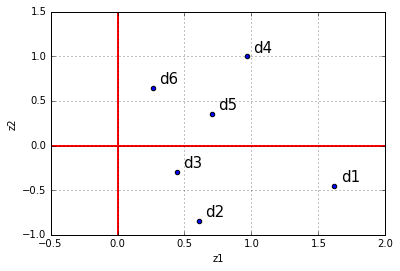

In [16]:
fig, ax = plt.subplots()
df.plot.scatter(x="z1", y="z2", ax=ax)
ax.axvline(x=0, lw=2, color='red') #x軸とy軸に線を引く
ax.axhline(y=0, lw=2, color='red') 
ax.set_xlim(-0.5, 2.0)
ax.set_ylim(-1.0, 1.5)
ax.grid(True)
for k, v in df.iterrows():
    ax.annotate(k, xy=(v[0]+0.05,v[1]+0.05),size=15) #データ点にラベル名を付与

文書$d1$と$d2$の特徴空間上での類似度を計算してみよう．

In [17]:
# d1とd2の特徴空間上での類似度を計算する
print("特徴空間上でのコサイン類似度 =",sim(D_k[:,0], D_k[:,1]))
print("M_k上での文書ベクトルのコサイン類似度 =", sim(M_k[:,0], M_k[:,1]))
print("なお，元の文書ベクトル上でのコサイン類似度 =", sim(M[:,0],M[:,1]))

特徴空間上でのコサイン類似度 = 0.781837380815
M_k上での文書ベクトルのコサイン類似度 = 0.781837380815
なお，元の文書ベクトル上でのコサイン類似度 = 0.408248290464


このように，次元削減された文書ベクトル$\{{\bf d}_i^{(k)}\}$間のコサイン類似度が，低ランク近似された単語-文書行列$M_k$における文書ベクトル間のコサイン類似度と一致することが分かる．

# クエリの特徴空間での表現

いま，$m$次元クエリべトル${\bf q}$が与えられたとき，特徴空間上でのベクトル表現${\bf q}^{(k)}$は以下の式で得られる．

${\bf q}^{(k)} = U_k^T {\bf q}$

In [41]:
q = np.array([1,0,1,1,0]) #文書d1と同じものをクエリとして用いてみる
q_k = np.dot(U_k.T, q)  #k次元特徴空間へ射影
print(q_k) # d_j^{k} と一致していることを確認
print("sim(q, d) =",sim(q_k, D_k[:,0])) #文書d1との特徴空間上での類似度

[ 1.62 -0.46]
sim(q, d) = 1.0


## 単語ベクトルの次元削減

$M_k = U_k \Sigma_k V_t^T$

文書ベクトルと同様に，今度は両辺に右から$V_k$をかけると

$M_k V_k = U_k \Sigma_k$ （$V_k^T V_k=I$より)

$U_k \Sigma_k =T_k $とおくと，

$T_k = U_k \Sigma_k$  

In [19]:
T_k  = np.dot(U_k, Sigma_k)
axis_names = ["z1", "z2"]
term_names = ["ship", "boat", "ocean", "voyge", "trip"]
df = pd.DataFrame(T_k, 
                  columns=axis_names, index=term_names) # np.r_ は行列同士の連結
df

,z1,z2
ship,0.95,-0.47
boat,0.28,-0.53
ocean,1.03,-0.81
voyge,1.52,0.56
trip,0.57,1.03


$T$の$i$行目と$j$行目がそれぞれ単語$i，j$の特徴空間上でのベクトル表現になる

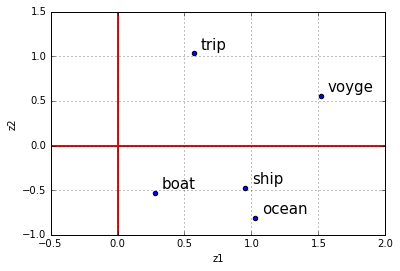

In [20]:
# 特徴空間上の単語ベクトルをプロット
fig, ax = plt.subplots()
df.plot.scatter(x="z1", y="z2", ax=ax)
ax.axvline(x=0, lw=2, color='red') #x軸とy軸に線を引く
ax.axhline(y=0, lw=2, color='red') 
ax.set_xlim(-0.5, 2.0)
ax.set_ylim(-1.0, 1.5)
ax.grid(True)
for k, v in df.iterrows():
    ax.annotate(k, xy=(v[0]+0.05,v[1]+0.05),size=15) #データ点にラベル名を付与

In [21]:
t_1 = T_k[0,:] #ship
t_2 = T_k[1,:] #boat

print("k次元特徴空間での類似度")
print("sim(ship, boat) =", sim(t_1, t_2))
print("元の空間での類似度")
print("sim(ship, boat) =", sim(M[0,:], M[1,:]))

k次元特徴空間での類似度
sim(ship, boat) = 0.811763741002
元の空間での類似度
sim(ship, boat) = 0.0


このように，元の単語-文書行列における単語ベクトルでは類似度が0であった単語間に対して高い類似度を与えることができていることが分かる．